In [ ]:
### Code used to combine the different datasets gathered through web crawling
### DO NOT NEED TO BE RUN If you have combined keyword dataset

import pandas as pd

file_paths = {
    "당뇨": 'ytn_monthly_당뇨.csv',
    "식품": 'ytn_monthly_식품.csv',
    "제로": 'ytn_monthly_제로.csv'
}

dataframes = [pd.read_csv(file) for file in file_paths.values()]
df_comb = pd.concat(dataframes, ignore_index=True)

keywords = ['건강', '식단', '영양', '다이어트', '채식', '비건', '유기농', '클린'] # keywords for determining level of interest in healthy foods

def contains_keywords(text):
    if pd.isnull(text):  
        return 0
    for keyword in keywords:
        if keyword in text:
            return 1
    return 0

df_comb['Contains_Healthy_Keyword'] = df_comb['title'].apply(contains_keywords)
df_comb['Month'] = pd.to_datetime(df_comb['date'], errors='coerce').dt.to_period('M')
monthly_df_comb = df_comb.groupby('Month')['Contains_Healthy_Keyword'].sum()

monthly_counts_df_comb = monthly_df_comb.reset_index()
monthly_counts_df_comb.columns = ['Month', 'Total']
monthly_counts_df_comb.set_index('Month', inplace=True)

df_comb.to_csv('ytn_combined_with_keywords.csv', index=False)

In [1]:
import pandas as pd
df = pd.read_csv('ytn_combined_with_keywords.csv')
df.head()

,title,url,date,target_found,Contains_Healthy_Keyword,Month
0,"美 전설적 토크쇼 진행자 래리 킹, 코로나19로 입원\n했습니다.\r\n\r\nCN...",https://www.ytn.co.kr/_ln/0104_202101031422112259,2021-01-03,NaN,0,2021-01
1,"'비스' 이영현, 33kg 감량 성공 비법 공개 ""달라진 성량 걱정"" \n 순탄치 ...",https://www.ytn.co.kr/_sn/0117_202101121510103119,2021-01-12,NaN,0,2021-01
2,[자막뉴스] 코로나19 완치 후에...무서운 증언\n 레스터대 연구팀이 영국의 코로...,https://www.ytn.co.kr/_ln/0134_202101190900354124,2021-01-19,NaN,0,2021-01
3,"코로나19 걸린 할아버지 위해 머리카락 판 손녀\n 것을 시작으로, 9명의 가족이 ...",https://www.ytn.co.kr/_ln/0134_202101091145018430,2021-01-09,NaN,0,2021-01
4,"고기 태울 때 나오는 연기, 당뇨병 발생 위험 높인다\nPAH( 다환방향족탄화수소)...",https://www.ytn.co.kr/_ln/0119_202101091030011683,2021-01-09,NaN,0,2021-01


In [8]:
df['Month'].value_counts().mean()


224.97826086956522

In [53]:
# Month
df['Month'] = pd.to_datetime(df['Month'], errors='coerce').dt.to_period('M')

# Count by month
df_= df.groupby('Month')['Contains_Healthy_Keyword'].sum()
df_ = df_.reset_index()
df_.columns = ['Month', 'Total']
df_.set_index('Month', inplace=True)

# smoothen the curve with moving average
df_['Total'] = df_['Total'].rolling(window=3, center=True).mean()
df_ = df_.dropna()

In [54]:
df_.head()

,Total
Month,
2021-02,21.000000
2021-03,21.666667
2021-04,22.000000
2021-05,25.666667
2021-06,25.000000


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19662D+00    |proj g|=  2.31855D-01

At iterate    5    f=  2.10322D+00    |proj g|=  1.36251D-01

At iterate   10    f=  2.05275D+00    |proj g|=  1.90358D-02

At iterate   15    f=  2.03733D+00    |proj g|=  1.37450D-02

At iterate   20    f=  2.03365D+00    |proj g|=  5.96986D-03

At iterate   25    f=  2.03273D+00    |proj g|=  9.89345D-03

At iterate   30    f=  2.03262D+00    |proj g|=  3.47579D-03

At iterate   35    f=  2.03251D+00    |proj g|=  2.51187D-03

At iterate   40    f=  2.03231D+00    |proj g|=  3.61084D-03

At iterate   45    f=  2.03207D+00    |proj g|=  3.21257D-03

At iterate   50    f=  2.03206D+00    |proj g|=  1.10904D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


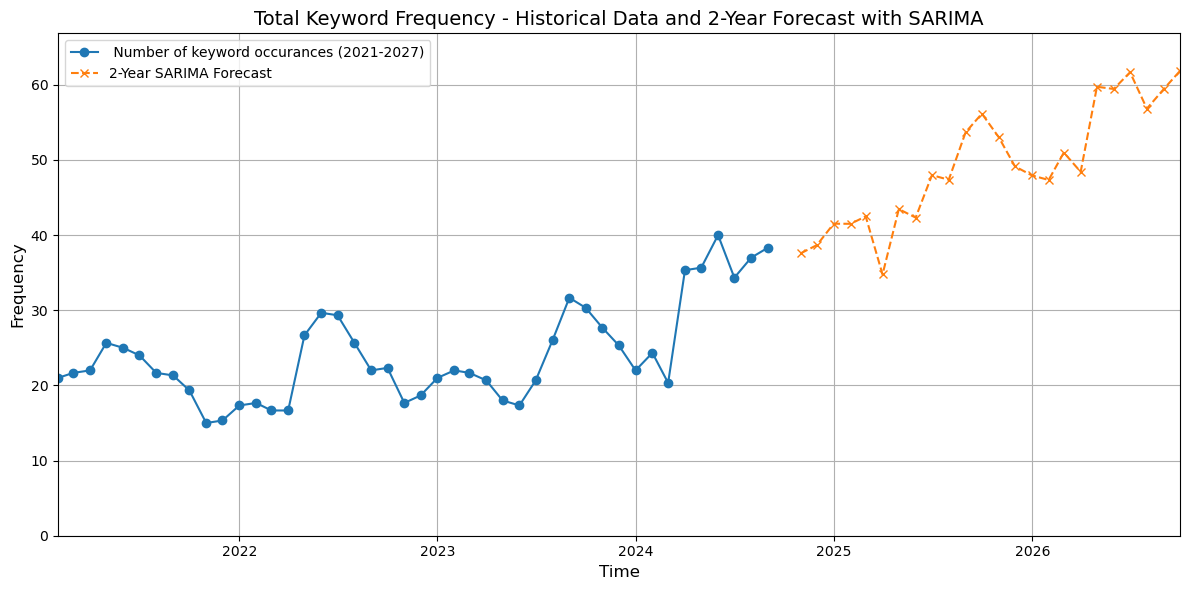

In [55]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

df_.index = df_.index.to_timestamp()

model_filtered = SARIMAX(df_['Total'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
fitted_model_filtered = model_filtered.fit()
forecast_filtered_2yr = fitted_model_filtered.forecast(steps=24) # forecast 2 years

future_index_filtered = pd.date_range(
    start=df_.index[-1] + pd.DateOffset(months=1),
    periods=24,
    freq='M'
)

plt.figure(figsize=(12, 6))

plt.plot(df_.index, df_['Total'], label=" Number of keyword occurances (2021-2027)", marker="o")

plt.plot(
    future_index_filtered,
    forecast_filtered_2yr,
    label="2-Year SARIMA Forecast",
    linestyle="--",
    marker="x",
)

plt.xlim(df_.index.min(), future_index_filtered[-1])

plt.ylim(0, max(df_['Total'].max(), forecast_filtered_2yr.max()) + 5)

plt.title("Total Keyword Frequency - Historical Data and 2-Year Forecast with SARIMA", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid()
plt.tight_layout()  
plt.show()